In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import os

## Question 2:
### Part 1
- Create your own dataset for text classification. It should contain at least 1000 words in total and at least two categories with at least 100 examples per category.

In [3]:
import zipfile
from google.colab import drive
import pandas as pd

csv_file_path = "/gdrive/MyDrive/sentiment_dataset.csv"

# Read CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

In [4]:
df

,sentence,sentiment
0,I absolutely love the new movie; it's a master...,Positive
1,The weather is fantastic today; I'm enjoying e...,Positive
2,My friends always make me feel supported and h...,Positive
3,This book is incredibly inspiring; it changed ...,Positive
4,I'm grateful for the opportunities that come m...,Positive
...,...,...
205,Just what I needed – a flat tire on Monday mor...,Negative
206,My computer crashed again. What a fantastic op...,Negative
207,Another rejection letter! Because who doesn't ...,Negative
208,"Oh, marvelous, the grocery store ran out of my...",Negative


In [5]:
sentiment_count = df['sentiment'].value_counts()
sentiment = sentiment_count.index
print("Unique sentiment:", sentiment)
sentiment_count


Unique sentiment: Index(['Negative', 'Positive'], dtype='object')


Negative    110
Positive    100
Name: sentiment, dtype: int64

In [6]:
df['word_count'] = df['sentence'].apply(lambda x: len(x.split()))

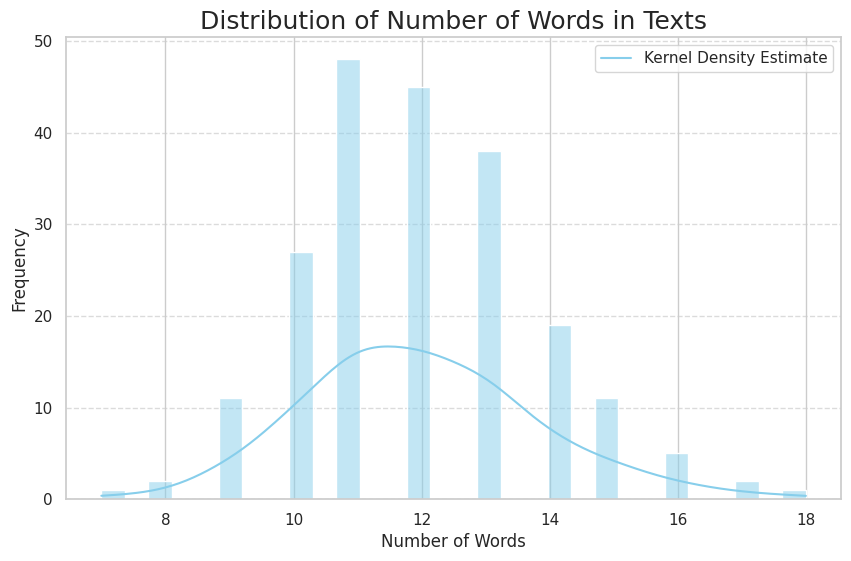

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.histplot(df['word_count'], bins=30, kde=True, color='skyblue')
ax.set(xlabel='Number of Words', ylabel='Frequency')
ax.set_title('Distribution of Number of Words in Texts', fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the legend
ax.legend(['Kernel Density Estimate'], loc='upper right')

# Show the plot
plt.show()


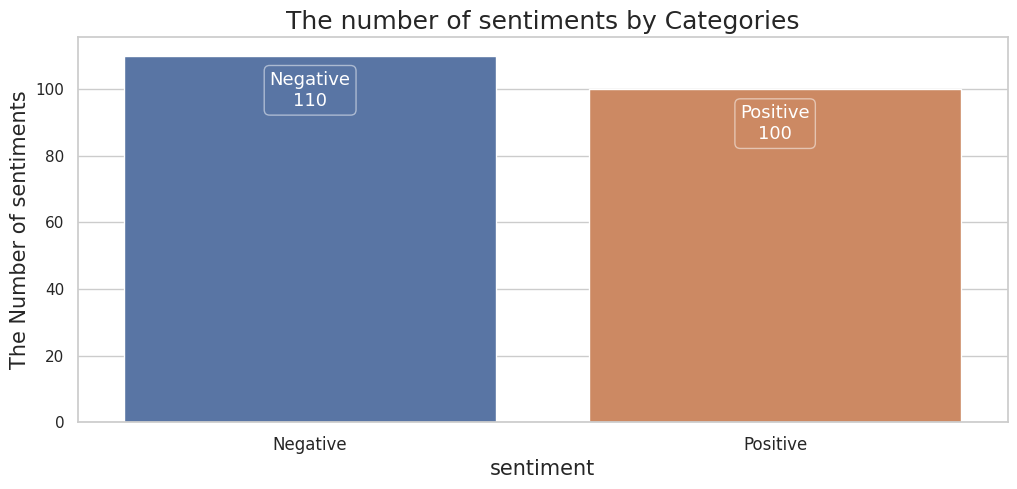

In [8]:
fig = plt.figure(figsize= (12, 5))
ax = fig.add_subplot(111)
sns.barplot(x = sentiment_count.index, y = sentiment_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{sentiment[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('sentiment', size = 15)

plt.ylabel('The Number of sentiments', size= 15)

plt.xticks(size = 12)

plt.title("The number of sentiments by Categories" , size = 18)

plt.show()


In [9]:
df['sentiment_boolean'] = df['sentiment'].astype('category').cat.codes
df

,sentence,sentiment,word_count,sentiment_boolean
0,I absolutely love the new movie; it's a master...,Positive,9,1
1,The weather is fantastic today; I'm enjoying e...,Positive,11,1
2,My friends always make me feel supported and h...,Positive,9,1
3,This book is incredibly inspiring; it changed ...,Positive,11,1
4,I'm grateful for the opportunities that come m...,Positive,9,1
...,...,...,...,...
205,Just what I needed – a flat tire on Monday mor...,Negative,17,0
206,My computer crashed again. What a fantastic op...,Negative,13,0
207,Another rejection letter! Because who doesn't ...,Negative,15,0
208,"Oh, marvelous, the grocery store ran out of my...",Negative,15,0


In [10]:
data_texts = df['sentence'].to_list()
data_labels = df['sentiment_boolean'].to_list()


### Part 2

### Performing Train and Test Split

In [11]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=42)

### Validating Train and Test Split

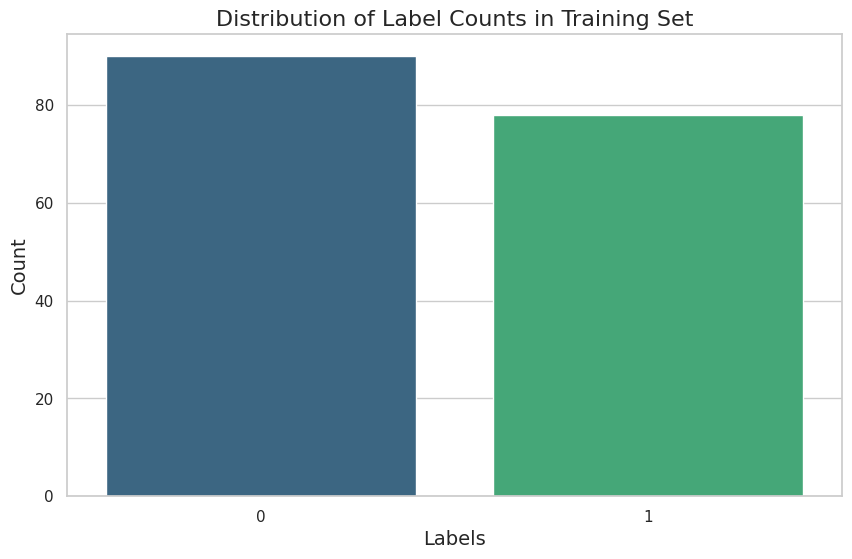

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming train_labels is a list containing your labels
item_counts = Counter(train_labels)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(item_counts.keys()), y=list(item_counts.values()), palette="viridis")
plt.title('Distribution of Label Counts in Training Set', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

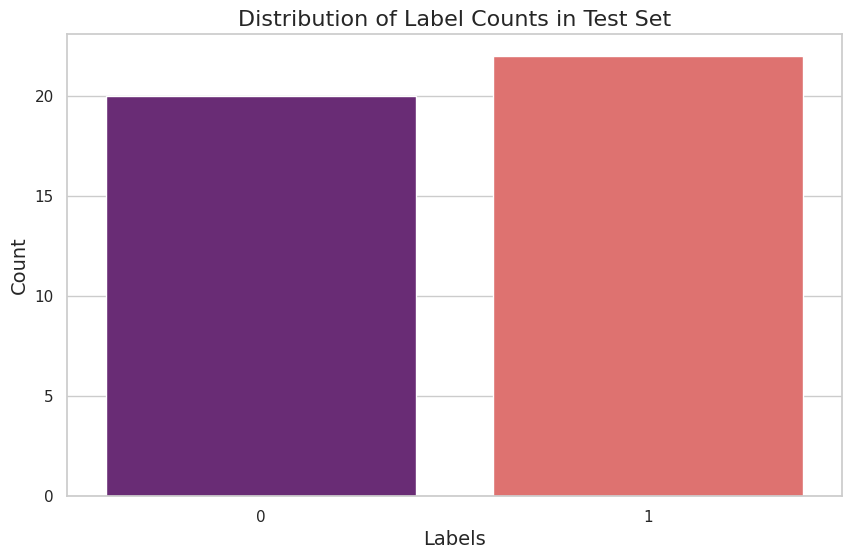

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming test_labels is a list containing your labels|
item_counts_test = Counter(test_labels)

# Create a bar plot for the test set
plt.figure(figsize=(10, 6))
sns.barplot(x=list(item_counts_test.keys()), y=list(item_counts_test.values()), palette="magma")
plt.title('Distribution of Label Counts in Test Set', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [14]:
import transformers
from tensorflow import keras
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)

test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [16]:
# Print the first example's encoding from the training set
print("Training Encoding - Example 1:")
print("Input IDs:", train_encodings['input_ids'][0])
print("Attention Mask:", train_encodings['attention_mask'][0])
print("\n")

# Print the first example's encoding from the test set
print("Test Encoding - Example 1:")
print("Input IDs:", test_encodings['input_ids'][0])
print("Attention Mask:", test_encodings['attention_mask'][0])
print("\n")

Training Encoding - Example 1:
Input IDs: [101, 1996, 5573, 4530, 1999, 4860, 3236, 2033, 4895, 28139, 19362, 2098, 1010, 2877, 2000, 17964, 1012, 102, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


Test Encoding - Example 1:
Input IDs: [101, 1996, 8013, 2326, 4387, 2001, 19776, 3512, 1998, 4895, 16001, 14376, 5313, 1012, 102, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]




In [17]:
# Training Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),  # Features: tokenized and encoded representations of training texts
    train_labels            # Labels: corresponding labels for the training texts
))

# Test Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),    # Features: tokenized and encoded representations of test texts
    test_labels              # Labels: corresponding labels for the test texts
))

In [18]:
# Print the contents of the training dataset
for features, labels in train_dataset.take(5):  # Print the first 5 examples for illustration
    print("Features:", features)
    print("Labels:", labels)
    print("\n")

Features: {'input_ids': <tf.Tensor: shape=(25,), dtype=int32, numpy=
array([  101,  1996,  5573,  4530,  1999,  4860,  3236,  2033,  4895,
       28139, 19362,  2098,  1010,  2877,  2000, 17964,  1012,   102,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(25,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)>}
Labels: tf.Tensor(0, shape=(), dtype=int32)


Features: {'input_ids': <tf.Tensor: shape=(25,), dtype=int32, numpy=
array([  101,  4087,  1043, 15909,  8376,  2076,  2019,  2590,  8312,
        3303, 14325,  1012,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(25,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)>}
Labels: tf.Tensor(0, shape=(), dtype=int32)


Features: 

### Part 3:

### Base pretrained model implementation:

In [35]:
# Import necessary components from the transformers library
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

for layer in model.layers[:-3]:
    layer.trainable = False
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

model.fit(train_dataset.shuffle(100).batch(16), epochs=3,
          validation_data=test_dataset.shuffle(100).batch(16)
          )



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
11/11 [==============================] - 71s 946ms/step - loss: 0.6670 - accuracy: 0.6667 - val_loss: 0.6309 - val_accuracy: 0.6667
Epoch 2/3
11/11 [==============================] - 5s 446ms/step - loss: 0.6003 - accuracy: 0.8095 - val_loss: 0.5587 - val_accuracy: 1.0000
Epoch 3/3
11/11 [==============================] - 6s 531ms/step - loss: 0.5369 - accuracy: 0.9226 - val_loss: 0.4899 - val_accuracy: 1.0000


In [36]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_99 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 592130 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________


### Transfer Learning: Model hyperparameter finetuning and training

In [49]:
base_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

for layer in base_model.layers[:-5]:
    layer.trainable = False

# Create a custom model by extending the base model
class CustomDistilBERTModel(tf.keras.Model):
    def __init__(self, base_model):
        super(CustomDistilBERTModel, self).__init__()
        self.base_model = base_model  # Store the base model
        self.dense_layer = tf.keras.layers.Dense(256, activation='relu')
        self.output_layer = tf.keras.layers.Dense(2, activation='softmax')

    def call(self, inputs, training=False):
        logits = self.base_model(inputs, training=training).logits
        dense_output = self.dense_layer(logits)
        predictions = self.output_layer(dense_output)
        return predictions

# Instantiate the custom model
ammended_model = CustomDistilBERTModel(base_model)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
ammended_model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=["accuracy"])

# Train the model
ammended_model.fit(train_dataset.batch(16), epochs=3, validation_data=test_dataset.batch(16))

# Evaluate the model on the test set
test_loss, test_accuracy = ammended_model.evaluate(test_dataset.batch(32))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
11/11 [==============================] - 44s 3s/step - loss: 0.6505 - accuracy: 0.8333 - val_loss: 0.5583 - val_accuracy: 1.0000
Epoch 2/3
11/11 [==============================] - 33s 3s/step - loss: 0.4822 - accuracy: 0.9881 - val_loss: 0.3972 - val_accuracy: 0.9762
Epoch 3/3
2/2 [==============================] - 1s 347ms/step - loss: 0.2421 - accuracy: 0.9762
Test Accuracy: 97.62%


In [50]:
ammended_model.summary()

Model: "custom_distil_bert_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_for_sequenc  multiple                  66955010  
 e_classification_17 (TFDis                                      
 tilBertForSequenceClassifi                                      
 cation)                                                         
                                                                 
 dense_22 (Dense)            multiple                  768       
                                                                 
 dense_23 (Dense)            multiple                  514       
                                                                 
Total params: 66956292 (255.42 MB)
Trainable params: 66956292 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
save_directory = "/saved_models"

ammended_model.save(save_directory)

tokenizer.save_pretrained(save_directory)

('/saved_models/tokenizer_config.json',
 '/saved_models/special_tokens_map.json',
 '/saved_models/vocab.txt',
 '/saved_models/added_tokens.json')

#### Predicting Sentiment for sample sentences

In [53]:
import pandas as pd

# Function to generate predicted labels for a dataset
def predict_labels(model, dataset):
    predicted_labels = []
    for batch in dataset:
        predictions = ammended_model.predict(batch[0])
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
    return predicted_labels

# Generate predicted labels on the test set
predicted_labels = predict_labels(ammended_model, test_dataset)


1/1 [==============================] - 0s 134ms/step


In [54]:
df_results = pd.DataFrame({
    'Test_Texts': test_texts,
    'Test_Labels': test_labels,
    'Predicted_Labels': predicted_labels
})


In [55]:
df_results.head(10)

,Test_Texts,Test_Labels,Predicted_Labels
0,The customer service representative was dismis...,0,0
1,The sudden change in plans left me feeling dis...,0,0
2,Connecting with nature during a hike rejuvenat...,1,1
3,The unexpected financial setback has caused st...,0,0
4,Rediscovering an old favorite song brings back...,1,1
5,The persistent noise from a nearby constructio...,0,0
6,Witnessing a random act of kindness in public ...,1,1
7,A surprise weekend getaway to a scenic locatio...,1,1
8,The beach vacation was relaxing and rejuvenati...,1,1
9,The unexpected increase in workload is overwhe...,0,0


In [56]:
label_mapping = dict(enumerate(df['sentiment'].astype('category').cat.categories))


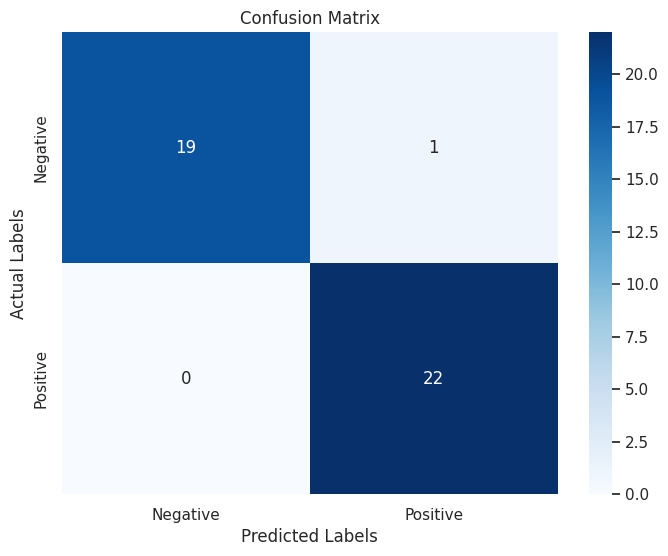


Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.95      0.97        20
    Positive       0.96      1.00      0.98        22

    accuracy                           0.98        42
   macro avg       0.98      0.97      0.98        42
weighted avg       0.98      0.98      0.98        42



In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming df_results has 'Test_Labels' and 'Predicted_Labels' columns
y_true = df_results['Test_Labels']
y_pred = df_results['Predicted_Labels']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=label_mapping.values())
print("\nClassification Report:")
print(class_report)


###  Discuss what could be done to improve accuracy

Despite achieving close to a 100% accuracy on a simplistic and straightforward artificial dataset, it's important to recognize that real-world scenarios present unique challenges. Here are some key aspects to investigate and address in order to enhance model accuracy in more complex and practical situations.

### Exploring Hyperparameters:

1. **Learning Rate:**
   - Adjust the learning rate for optimal convergence without overshooting or slowing down.

2. **Batch Size:**
   - Experiment with different batch sizes for stable training and memory efficiency.

3. **Number of Epochs:**
   - Tune the number of epochs to avoid overfitting and find the right training duration.

4. **Fine-Tuning Transformer Layers:**
   - Experiment with freezing and training transformer layers for optimal pre-trained features.

### Model training and prediction:

1. **Try different model architectures:**
   - Switch to a larger model like BERT for more complex pattern capture.

2. **Batch Normalization:**
   - Improve training stability with batch normalization.

3. **Learning Rate Schedule:**
   - Implement schedules like warm-up or decay for adaptive learning.

4. **Early Stopping:**
   - Halt training when performance plateaus to prevent overfitting.

5. **Ensemble Learning:**
   - Combine predictions from multiple models for robustness.

6. **Domain-Specific Considerations:**
   - Adapt model and hyperparameters for domain-specific tasks.

Ensure continuous evaluation at each step to achieve the right balance.
